In [159]:
import numpy as np
import os
from utils2 import * 
import skimage.io as io
import sys
sys.stdout = open('prints.txt', 'w')


args = {
        "path": "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/",
        "idx": 89,
        "energy_kev": 18.0,
        "detector_pixel_size": 2.57 * 1e-6,
        "distance_sample_detector": 0.15,
        "alpha": 1e-8,
        "delta_beta": 1,
        "pad": 1,
        "method": 'TIE',
        'iter_num': 500,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
        'seed': 42,
        'filter': True,
        'generator': None,
        'discriminator': None,
        'filter_optimizer': None,
        'generator_optimizer': None,
        'discriminator_optimizer': None,
    }

def save_path_generator(**kwargs):
    assert 'image_path' in kwargs.keys(), 'image_path is not provided'
    if type(kwargs['image_path']) is list:
        file_name = [os.path.splitext(os.path.basename(path))[0] for path in kwargs['image_path']]
        folder = os.path.basename(os.path.dirname(kwargs['image_path'][0]))
    else:
        file_name = os.path.splitext(os.path.basename(kwargs['image_path']))[0]
        folder = os.path.basename(os.path.dirname(kwargs['image_path']))

    init_path = os.getcwd() + '/data/saved_weights/' + folder + '/'
    save_wpath = os.getcwd() + '/data/retrieved/' + folder + '/'
    if not os.path.exists(init_path):
        os.makedirs(init_path)
    if not os.path.exists(save_wpath):
        os.makedirs(save_wpath)
    kwargs['file_name'] = file_name
    kwargs['save_wpath'] = save_wpath
    kwargs['init_wpath'] = init_path
    return kwargs 


def get_all_info(path = None, images = None, idx = 89, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1e1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None, **kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    assert type(idx) is list or type(idx) is int, 'idx must be a list or an integer'
    if path is not None:
        images = list(io.imread_collection(path + '/*.tif').files) or list(io.imread_collection(path + '/*.tiff').files)
        # images = sorted(glob(path + '/*.tif'))
        if type(idx) is list:
            try:
                image_path = [images[i] for i in idx]
            except:
                image_path = [images[i] for i in range(len(idx))]
            image = load_images_parallel(image_path)
            shape_x = image[0].shape[0]
            shape_y = image[0].shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = len(idx)
            print("images are of leng", len(image))
            std = [np.std(i) for i in image]
            mean = [np.mean(i) for i in image]
        else:
            image_path = images[idx]
            image = load_image(image_path)
            shape_x = image.shape[0]
            shape_y = image.shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = 1
            std = [np.std(image)]
            mean = [np.mean(image)]
        assert images is not None, "either image or path should be provided"
        
    else:
        assert images is not None, "either image or path should be provided"
        image_path = images[idx]
        image = load_image(images[idx])
        Fx, Fy = grid_generator(image.shape[0], image.shape[1], upscale=1, ps = detector_pixel_size)
        shape_x = image.shape[0]
        shape_y = image.shape[1]
        ND = 1
        std = [np.std(image)]
        mean = [np.mean(image)]
    
    
    if phase_path is not None and attenuation_path is not None:
        phase_images = io.imread_collection(phase_path + '/*.tif').files
        attenuation_images = io.imread_collection(attenuation_path + '/*.tif').files
        if type(idx) is list:
            phase_image_path = []
            attenuation_image_path = []
            for i in idx:
                phase_image_path.append(phase_images[i])
                attenuation_image_path.append(attenuation_images[i])
            phase_image = load_images_parallel(phase_image_path)
            attenuation_image = load_images_parallel(attenuation_image_path)
        else:
            phase_image_path = phase_images[idx]
            attenuation_image_path = attenuation_images[idx]
            phase_image = load_image(phase_image_path)
            attenuation_image = load_image(attenuation_image_path)

    fresnel_factor = fresnel_operator(shape_x, shape_y, detector_pixel_size, distance_sample_detector, energy_kev)
    
    kwargs = {
        "path": path,
        "output_path" : os.getcwd(),
        
        "idx": idx,
        "column_name": 'path',
        "energy_J": energy_kev_to_joule(energy_kev),
        "energy_kev": energy_kev,
        "lam": wavelength_from_energy(energy_kev),
        "detector_pixel_size": detector_pixel_size,
        "distance_sample_detector": detector_pixel_size,
        "fresnel_number": fresnel_calculator(energy_kev = energy_kev, detector_pixel_size = detector_pixel_size, distance_sample_detector = distance_sample_detector),
        "wave_number": wave_number(energy_kev),
        "fresnel_factor": fresnel_factor,

        "shape_x": shape_x,
        "shape_y": shape_y,
        "pad_mode": 'symmetric',
        'shape': [int(shape_x), int(shape_y)],
        'nx': int(shape_x), 'ny': int(shape_y),
        'distance': [distance_sample_detector], 
        'energy': energy_kev, 
        'alpha': alpha, 
        'pad': pad,
        'nfx': int(shape_x) * pad, 
        'nfy': int(shape_y) * pad,
        'pixel_size': [detector_pixel_size, detector_pixel_size],
        'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
        'fx': Fx, 'fy': Fy,
        'method': method, 
        'delta_beta': delta_beta,

        "image_path": image_path,
        "image": image,
        "images": images,
        "ND": ND,
        "std": std,
        "mean": mean,
        "phase_path": phase_path,
        "attenuation_path": attenuation_path,
        'phase_image': phase_image,
        'attenuation_image': attenuation_image,
    } 
    kwargs.update(save_path_generator(**kwargs))
    return kwargs



In [168]:
from models import make_generator, make_discriminator, make_filter
from utils import RECONmonitor, ffactor, fresnel_operator, visualize

import skimage.io as io

import tensorflow as tf
import os
import numpy as np
import time

# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss


def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))



# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss


# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss



def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

def FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None):
    """  Parameters: 
            E0 - initial complex field in x-y source plane
            detector_pixel_size - pixel size in microns
            lambda0 - wavelength in nm
            distance_sample_detector - distance_sample_detector-value (distance from sensor to object)
            background - optional background image to divide out from
        
        Returns: E1 - propagated complex field in x-y sensor plane"""  
    import os
    dtype = tf.complex64
    H = tf.cast(ff, dtype)
    detector_wavefield = tf.exp(tf.complex(-absorption, phase))
    detector_wavefield = tf.cast(detector_wavefield, dtype)
    # Compute FFT centered about 0
    E0fft = (tf.signal.fft2d(detector_wavefield))
    E0fft = tf.cast(E0fft, dtype)

    # Multiply spectrum with fresnel phase-factor
    print("E0fft shape: ", E0fft.shape, "H shape: ", H.shape)
    G = H * E0fft
    # Ef = tf.signal.ifft2d(tf.signal.ifftshift(G)) # Output after deshifting Fourier transform
    I = tf.abs(tf.signal.ifft2d(G))**2
    I = tf.cast(I, tf.float32)
    if dark_image is not None and ref_image is not None:
        I = I * (ref_image - dark_image) + dark_image
    I = tfnor_phase(tf.reshape(I, [1, I.shape[0], I.shape[1], 1]))
    return I

def phase_fresnel(phase, absorption, ff, px, py):
    paddings = tf.constant([[px // 2, py // 2], [px // 2, py // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tfnor_phase(ifp)
    return ifp


def ssim_check(image, rec, ff, distance_sample_detector):
    px, py = image.shape
    propagated = FresnelPropagator(rec[1], rec[0], ff, distance_sample_detector)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    print("SSIM between the input image and the reconstructed image is {}".format(ssim))
    return ssim

def peak_signal_to_noise(image, rec_phantom, ff, distance_sample_detector):
    px, py = image.shape
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, distance_sample_detector)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    # visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    psnr = tf.image.psnr(data_im, propagated, max_val = 1.0)
    print("Noise to signal ratio is {}".format(psnr))
    return psnr

class GANphase():
    def __init__(self, transformed_images[0,:,:,0], energy, distance_sample_detector, detector_pixel_size, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.transformed_images[0,:,:,0] = transformed_images[0,:,:,0]
        self.energy = energy
        self.distance_sample_detector = distance_sample_detector
        self.detector_pixel_size = detector_pixel_size
        super(GANphase, self).__init__()
    def make_model(self):
        if self.filter is True:
            self.filter = make_filter(self.transformed_images[0,:,:,0].shape[0],
                                  self.transformed_images[0,:,:,0].shape[1])
        self.generator = make_generator(self.transformed_images[0,:,:,0].shape[0],
                                        self.transformed_images[0,:,:,0].shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        2)
        self.discriminator = make_discriminator(self.transformed_images[0,:,:,0].shape[0],
                                                self.transformed_images[0,:,:,0].shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, transformed_images[0,:,:,0], ff):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(transformed_images[0,:,:,0])
            # recon = tfa.image.median_filter2d(recon)
            phase = tfnor_phase(recon[:, :, :, 0]) 
            phase = tf.reshape(phase, [self.px, self.py])
            absorption = (tfnor_phase(recon[:, :, :, 1]))* self.abs_ratio 
            absorption = tf.reshape(absorption, [self.px, self.py])
            if self.phase_only:
                absorption = tf.zeros_like(phase)
            # i_rec = phase_fresnel(phase, absorption, ff, self.px)
            i_rec = tfnor_phase(tf.reshape(FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None), [1, self.px, self.py, 1]))
            # i_rec = tf.reshape(FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None), [1, self.px, self.py, 1])
            
            real_output = self.discriminator(transformed_images[0,:,:,0], training=True)
            fake_output = self.discriminator(i_rec, training=True)
            g_loss = generator_loss(fake_output, transformed_images[0,:,:,0], i_rec, self.l1_ratio)
            d_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))


        return {'phase': phase,
                'absorption': absorption,
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss}


    @property
    def recon(self):
        # ff = ffactor(self.px * 2, self.py * 2, self.energy, self.distance_sample_detector, self.detector_pixel_size)
        # print(ff.shape, ff.max(), ff.min())
        ff = fresnel_operator(self.px, self.py, self.detector_pixel_size, self.distance_sample_detector, self.energy)
        transformed_images[0,:,:,0] = np.reshape(self.transformed_images[0,:,:,0], (1, self.px, self.py, 1))
        transformed_images[0,:,:,0] = tf.cast(transformed_images[0,:,:,0], dtype=tf.float32)
        self.make_model()

        if self.init_model:
            self.generator.load_weights(self.init_wpath+'generator.h5')
            print('generator is initilized')
            self.discriminator.load_weights(self.init_wpath+'discriminator.h5')

        phase = np.zeros((self.iter_num, self.px, self.py))
        absorption = np.zeros((self.iter_num, self.px, self.py))
        gen_loss = np.zeros(self.iter_num)

        ###########################################################################
        # Reconstruction process monitor
        if self.recon_monitor:
            plot_x, plot_loss = [], []
            recon_monitor = RECONmonitor('phase')
            recon_monitor.initial_plot(self.transformed_images[0,:,:,0])
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            step_results = self.rec_step(transformed_images[0,:,:,0], ff)
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            # phase[epoch, :, :], absorption[epoch, :, :], i_rec, gen_loss[epoch], d_loss = self.rec_step(transformed_images[0,:,:,0],
            #                                                                                                   ff)
            ###########################################################################

            plot_x.append(epoch)
            plot_loss = gen_loss[:epoch + 1]
            if (epoch + 1) % 100 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)
                if recon_monitor:
                    i_rec = np.reshape(i_rec, (self.px, self.py))
                    i_diff = np.abs(i_rec - self.transformed_images[0,:,:,0])
                    phase_plt = np.reshape(phase[epoch], (self.px, self.py))
                    recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss)
                    # lib.plot_or_show_images([i_rec, self.transformed_images[0,:,:,0], i_diff, phase_plt], show_or_plot = "show")
                    
                # print(phase.max(), phase.min())
                print('Iteration {}: G_loss is {} and D_loss is {}'.format(epoch + 1, gen_loss[epoch], d_loss.numpy()))
        recon_monitor.close_plot()
        
        if self.save_wpath != None:
            import skimage.io as io
            self.generator.save(self.init_wpath+'generator.h5')
            self.discriminator.save(self.init_wpath+'discriminator.h5')
            io.imsave(self.save_wpath+ 'final_phase_iter_' +str(self.iter_num)+'.tif', phase[epoch][1], check_contrast=False)
            io.imsave(self.save_wpath+ 'final_absorption_iter_' +str(self.iter_num)+'.tif', absorption[epoch][0], check_contrast=False)
        return absorption[epoch], phase[epoch]

def _get_GANphase_kwargs():
    return{
        'iter_num': 500,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
    }



def run_ganphase(**kwargs):
    "running this code will cause memory leak, please use run_ganphase_parallel instead"
    gan_phase_object = GANphase(**kwargs)
    start = time.time()
    rec = gan_phase_object.recon
    end = time.time()
    visualize(rec)
    return rec, gan_phase_object


In [169]:
def tfnor_phase(img):
    if type(img) is np.ndarray or type(img) is tf.Tensor:
        if len(img.shape) == 2:
            img = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
    elif type(img) is list:
        if len(img[0].shape) == 2:
            img = tf.stack([tf_reshape(i) for i in img])
    else:
        raise TypeError("img must be a list, np.ndarray or tf.Tensor")
    print(img.shape, "before normalization")
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    # if len(img.shape) == 3:
    img = tf.reshape(img, [img.shape[0], img.shape[1], img.shape[2], 1])
    return img

def tf_reshape(img):
    img = tf.reshape(img, [img.shape[0], img.shape[1], 1])
    img = tf.cast(img, tf.float32)
    return img

class Ganrec_Dataloader():
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.kwargs.update(get_all_info(**kwargs))
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        self.tranformed_images = None

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            keys = kwargs.keys()
            [self.__setattr__(key, kwargs[key]) for key in keys]
            
            if type(idx) is not list:    
                self.tranformed_images = tfnor_phase(self.image)
            else:
                images = [tfnor_phase(self.image[i]) for i in range(len(self.idx))]
                self.tranformed_images= tf.stack(images)
        else:
            if type(self.idx) is not list:
                self.tranformed_images = tfnor_phase(self.image)
            else:
                self.tranformed_images = tf.stack([tfnor_phase(self.image[i]) for i in range(len(self.idx))])
        return self.tranformed_images
    def normalize(self, idx = None):
        image = self.__getitem__(idx)
        image = tfnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, random = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            keys = kwargs.keys()
            [self.__setattr__(key, kwargs[key]) for key in keys]
            images = self.image
        else:
            images = self.image
        if type(images) is not list:
            images = [images]

        rows = int(np.sqrt(len(images)))
        if rows ==1:
            cols = len(images)
        else:
            cols = rows + 1
        print("rows: {}, cols: {}".format(rows, cols))
        if random == False:
            visualize(images, rows = rows, cols = cols)
        else:
            visualize(images, rows = rows, cols = cols, random=True)

    def normal_visualize(self, idx = None, random = False):
        if self.tranformed_images is None:
            self.__getitem__(idx)
        print(self.tranformed_images.shape)
        images = [self.tranformed_images[i, :, :, 0].numpy() for i in range(self.tranformed_images.shape[0])]
        rows = int(np.sqrt(len(images)))
        cols = rows + 1
        if random == False:    
            visualize(images, rows = rows, cols = cols, random = False )
        else:
            visualize(images, random=True)

    def train_model(self, idx = None, **kwargs):
        if self.tranformed_images is None:
            self.__getitem__(idx)
        keys = ['i_input', 'z', 'lam', 'pv', 'iter_num']
        vals = [self.tranformed_images[0,:,:,0], self.distance_sample_detector, self.lam, self.detector_pixel_size, self.iter_num]
        for key in keys:
            if key in kwargs.keys():
                self.kwargs[key] = kwargs[key]
            else:
                self.kwargs[key] = vals[keys.index(key)]
        self.kwargs['i_input'] = self.tranformed_images[0,:,:,0]
        self.kwargs["z"] = self.kwargs["distance_sample_detector"]
        self.kwargs["lam"] = self.kwargs["lam"]
        self.kwargs["pv"] = self.kwargs["detector_pixel_size"]
        self.kwargs['iter_num'] = self.kwargs['iter_num']

        gan_phase_object_phantom = GANphase(**self.kwargs)
        self.retrieved = gan_phase_object_phantom.recon
        self.generator = gan_phase_object_phantom.generator
        self.discriminator = gan_phase_object_phantom.discriminator
        
        self.attenuation = self.retrieved[0]
        self.phase = self.retrieved[1]
        self.propagated_forward = gan_phase_object_phantom.forward_propagate()
        
        visualize([self.tranformed_images[0,:,:,0], self.propagated_forward[0,:,:,0], self.attenuation, self.phase[:,:]], rows = 2, cols = 2)
        return self.retrieved
    
    def forward_propagate(self):
        return FresnelPropagator(self.phase, self.attenuation, self.fresnel_factor, self.distance_sample_detector)

    def ssim_check(self):
        self.ssim_value = tf.image.ssim(self.i_input, self.propagated_forward, max_val = 1.0)
        print("SSIM value is {}".format(self.ssim_value))
        return self.ssim_value


In [173]:
args["idx"] = 3
dataloader = Ganrec_Dataloader(**args)
trial = GANphase(input = dataloader.tranformed_images(), energy = dataloader.energy, distance_sample_detector = dataloader.distance_sample_detector, detector_pixel_size = dataloader.detector_pixel_size, **dataloader.kwargs)

TypeError: 'NoneType' object is not callable

In [163]:
trial.generator

AttributeError: 'GANphase' object has no attribute 'generator'

2023-06-21 10:14:42.420479: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-21 10:14:42.560173: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2023-06-21 10:14:43.602145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-21 10:14:48.639106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-21 10:14:59.719866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10


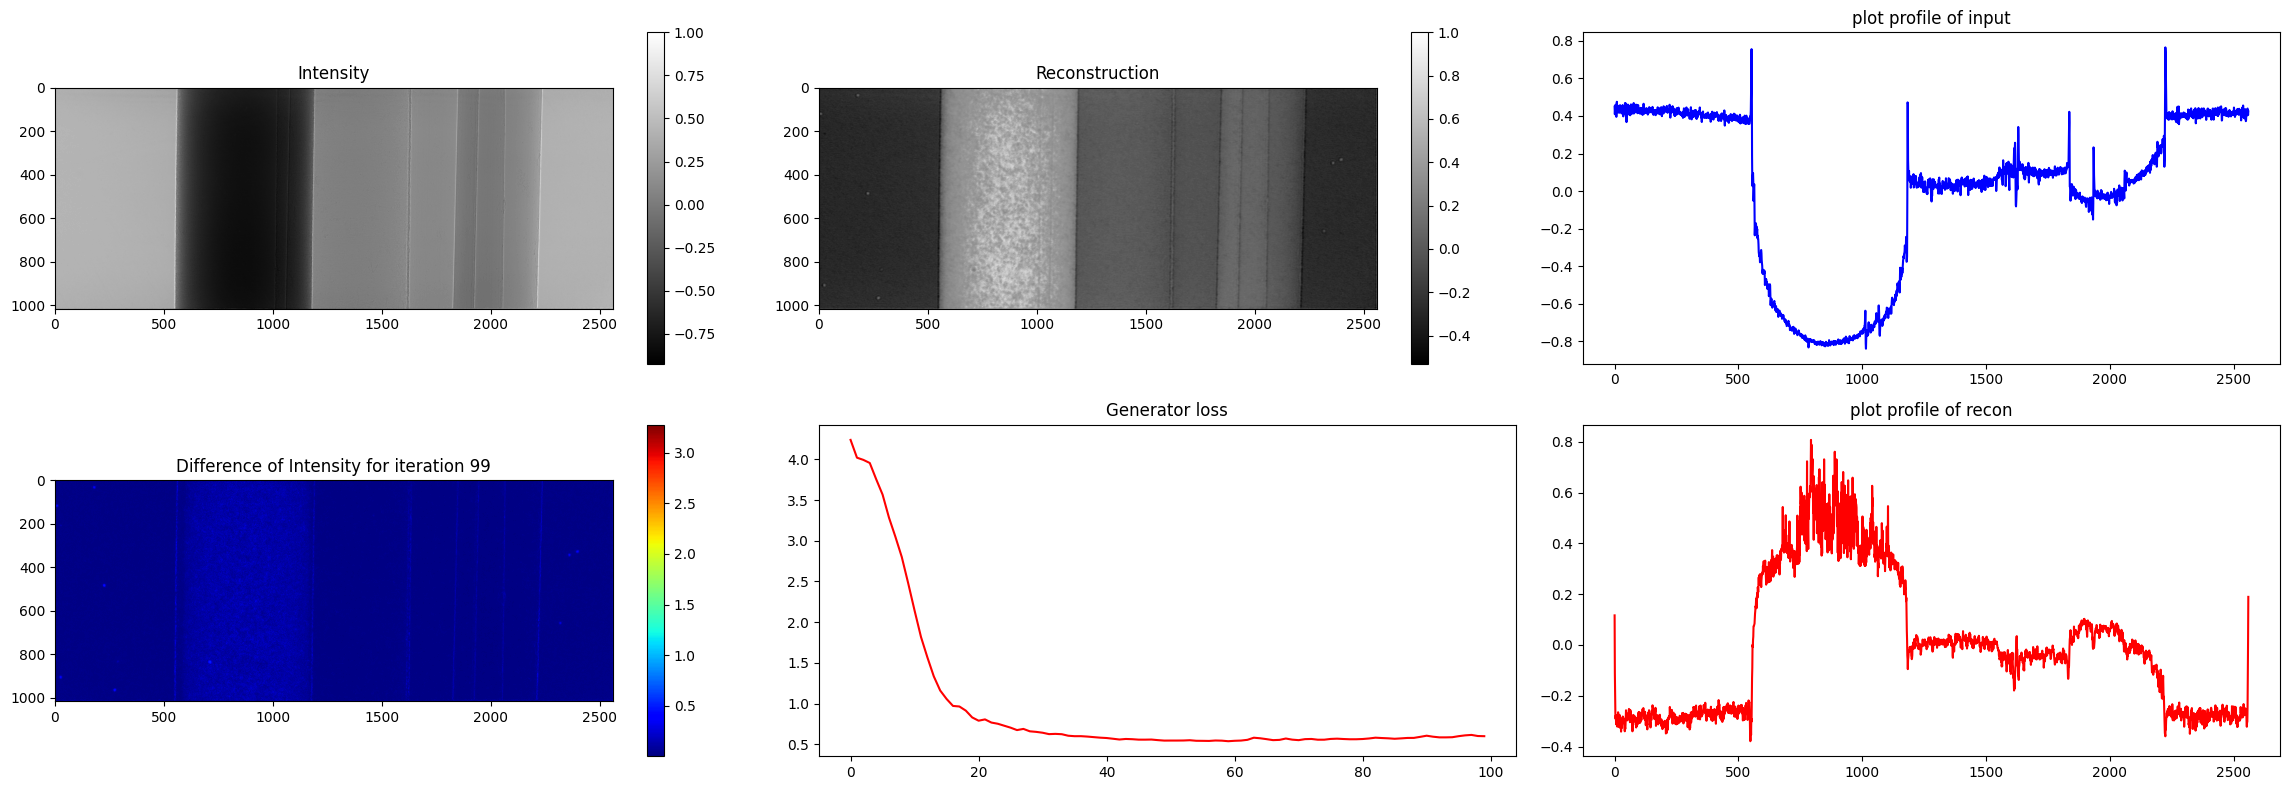

(array([[-0.00104777, -0.00996224, -0.01592842, ..., -0.02226376,
         -0.01324456, -0.00857769],
        [-0.00720525, -0.02445392, -0.03499622, ..., -0.03604278,
         -0.0307727 , -0.0222018 ],
        [-0.00895091, -0.03622273, -0.04652203, ..., -0.05708961,
         -0.048594  , -0.03007659],
        ...,
        [-0.01423991, -0.03939746, -0.03931823, ..., -0.06949201,
         -0.05698784, -0.03503958],
        [ 0.00188044, -0.01635124, -0.02926377, ..., -0.03948503,
         -0.02499901, -0.01620205],
        [ 0.00249496, -0.01842063, -0.0215514 , ..., -0.02779338,
         -0.0161521 , -0.00603661]]),
 array([[ 0.22217163,  0.16997626,  0.06842998, ...,  0.08828078,
          0.17816035,  0.25316179],
        [ 0.13124432, -0.02906175, -0.13250282, ..., -0.1950821 ,
         -0.03741656,  0.13054797],
        [ 0.06736447, -0.12992454, -0.25264636, ..., -0.28421122,
         -0.18293951,  0.08081677],
        ...,
        [ 0.08826997, -0.15992324, -0.27801397, ..., -

In [133]:
# args["idx"] = list(np.random.randint(100, 1000, 3))
args["idx"] = 3
dataloader = Ganrec_Dataloader(**args)
# dataloader.visualize()
# dataloader.normal_visualize()
# dataloader.train_model()

In [136]:
dataloader.save_wpath

'/beegfs/desy/user/hailudaw/git_folders/ganrec/ganrec/data/retrieved/rawBin2/'